In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import copy

In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)

from problem_formulation import get_model_for_problem_formulation
from dike_model_function import DikeNetwork

problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [5]:
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [6]:
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [7]:
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x000001C25046E480>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x000001C25046E480>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x000001C25046E480>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x000001C25046E480>)
ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x000001C25046E480>)
ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x000001C25046E480>)
ScalarOutcome('A.4 Total Costs', variable_name=('A.4_Expected Annual Dama

In [8]:
from ema_workbench import Policy
from itertools import product

# Define a base policy where all other levers have fixed values (all RfR values set to 0)
base_policy = {
    '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0,
    '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0,
    '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0,
    '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0,
    '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0,
}

# Define the possible values for dike increases
dike_increase_values = [0, 5, 10]

# Create Cartesian product of the EWS_DaysToThreat and dike increase values
combinations = list(product(dike_increase_values, repeat=5))

# Create policies with all combinations of EWS_DaysToThreat and dike increases
policies = []
policy_counter = 1

for dike_vals in combinations:
    policy_name = f'policy_{policy_counter}'
    policy_values = base_policy.copy()
    
    # Set the same dike increase value for each timestep for each dike
    for i in range(5):
        for j in range(3):
            policy_values[f'A.{i+1}_DikeIncrease {j}'] = dike_vals[i]

    policies.append(Policy(policy_name, **policy_values))
    policy_counter += 1

# Display the number of defined policies
print(f'Total number of policies: {len(policies)}')
print(policies)

Total number of policies: 243
[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}), Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_D

In [7]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=100)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 100 policies * 1 model(s) = 100000 experiments
100%|████████████████████████████████| 100000/100000 [5:17:16<00:00,  5.25it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
experiments, outcomes = results

In [9]:
import csv

csv_file = 'dikerings_results.csv'

# Open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write each tuple to the CSV file
    for row in results:
        writer.writerow(row)

In [10]:
df = pd.read_csv('dikerings_results.csv')
df

A.0_ID flood wave shape                       A.1_Bmax        A.1_Brate  \
0         A.1 Total Costs  A.1_Expected Number of Deaths  A.2 Total Costs   

                       A.1_pfail         A.2_Bmax  \
0  A.2_Expected Number of Deaths  A.3 Total Costs   

                       A.2_Brate        A.2_pfail  \
0  A.3_Expected Number of Deaths  A.4 Total Costs   

                        A.3_Bmax        A.3_Brate  \
0  A.4_Expected Number of Deaths  A.5 Total Costs   

                       A.3_pfail  ... A.4_DikeIncrease 0 A.4_DikeIncrease 1  \
0  A.5_Expected Number of Deaths  ...                NaN                NaN   

   A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
0                 NaN                 NaN                 NaN   

   A.5_DikeIncrease 2  EWS_DaysToThreat  scenario  policy  model  
0                 NaN               NaN       NaN     NaN    NaN  

[1 rows x 53 columns]

In [27]:
from ema_workbench.analysis import prim

data = outcomes['A.2 Total Costs']

y = data > np.percentile(data,90)

prim_alg = prim.Prim(experiments,y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 100000 points remaining, containing 10000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.07, coverage: 0.7, density: 1.0 restricted_dimensions: 7


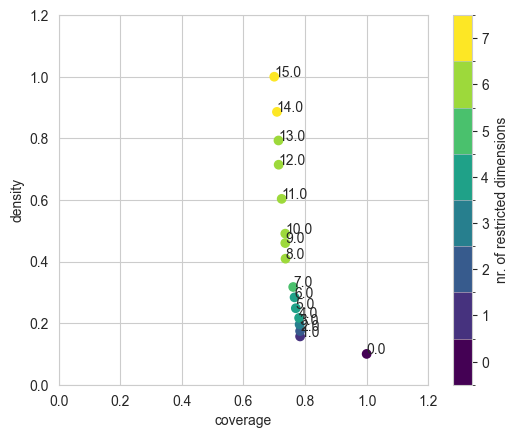

In [28]:
box1.show_tradeoff(annotated=True)
plt.show()

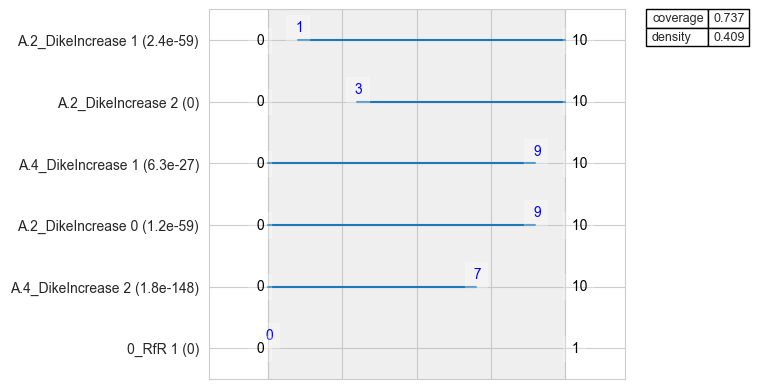

In [32]:
point = 8
box1.inspect(point, style='graph')
plt.show()

KeyboardInterrupt: 

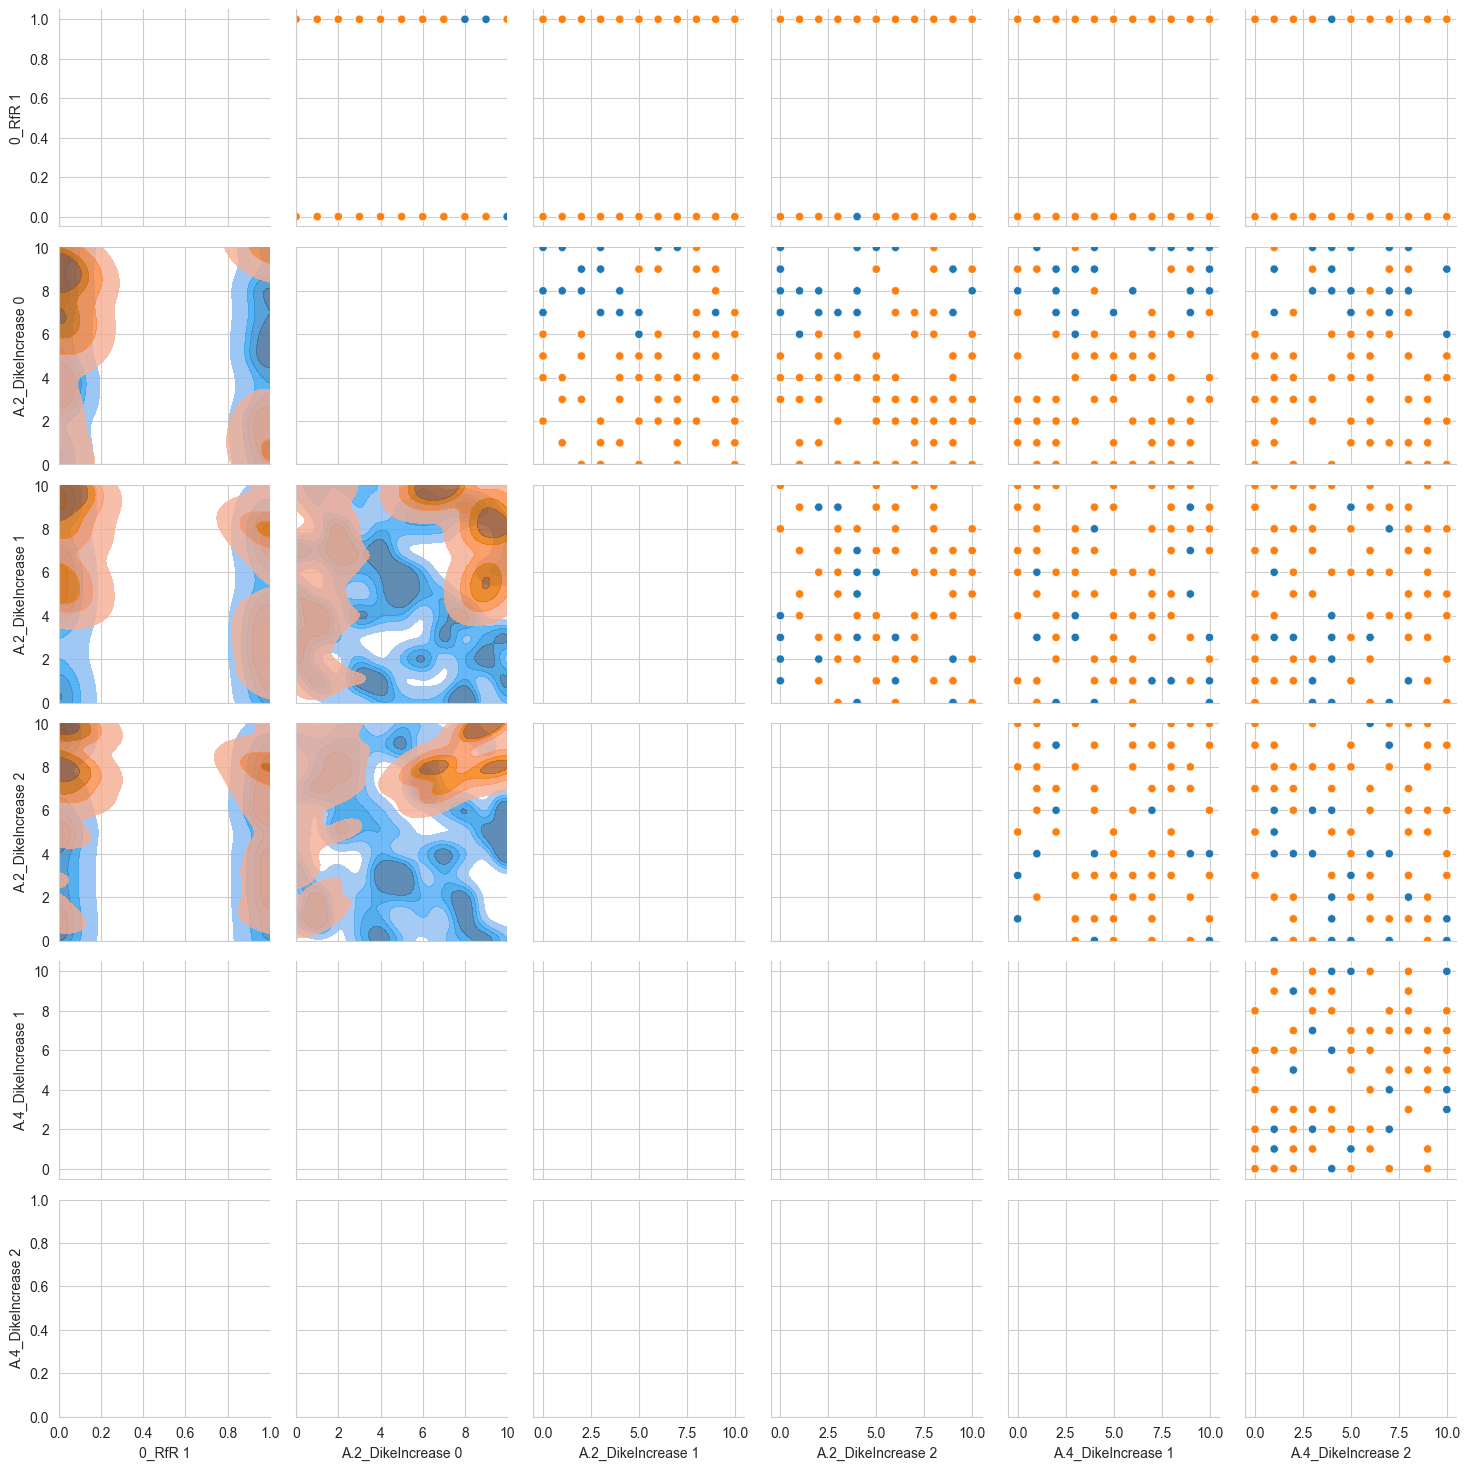

In [16]:
box1.select(11)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [26]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(experiments, data)

[MainProcess/INFO] model dropped from analysis because only a single category


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

In [25]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [28]:
import statsmodels.api as sm

X = pd.DataFrame(experiments).drop(['model','policy'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(outcomes['RfR Total Costs'], X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.523e+28
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:55:10   Log-Likelihood:             1.0688e+05
No. Observations:               11250   AIC:                        -2.137e+05
Df Residuals:                   11198   BIC:                        -2.133e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    8

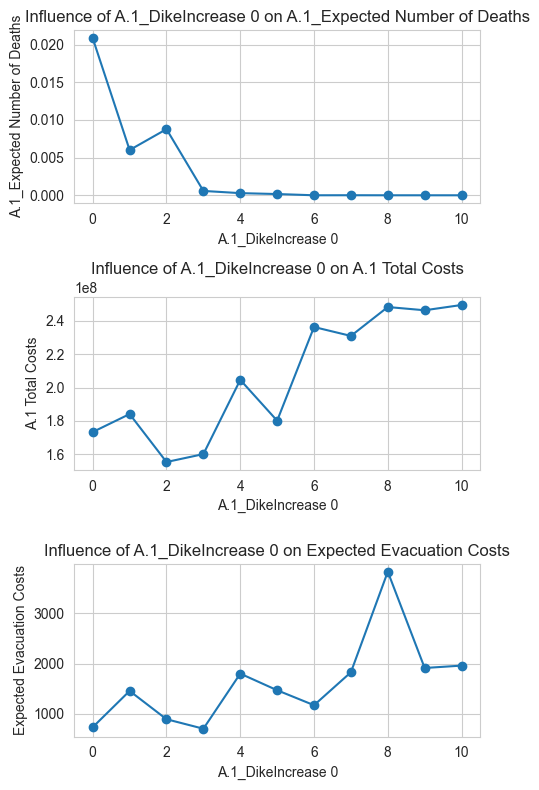

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `experiments` and `outcomes` are DataFrames obtained from the EMA Workbench results
experiments, outcomes = results

# Convert experiments and outcomes to DataFrames for easier manipulation
experiments_df = pd.DataFrame(experiments)
outcomes_df = pd.DataFrame(outcomes)

# Combine experiments and outcomes into a single DataFrame
combined_df = pd.concat([experiments_df, outcomes_df], axis=1)

# Focus on the relevant lever and outcomes
lever_name = 'A.1_DikeIncrease 0'
outcome_names = ['A.1_Expected Number of Deaths', 'A.1 Total Costs', 'Expected Evacuation Costs']

# Group by the lever values and calculate mean of outcomes
grouped_df = combined_df.groupby(lever_name)[outcome_names].mean().reset_index()

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 8))

for i, outcome in enumerate(outcome_names):
    axes[i].plot(grouped_df[lever_name], grouped_df[outcome], marker='o')
    axes[i].set_title(f'Influence of {lever_name} on {outcome}')
    axes[i].set_xlabel(lever_name)
    axes[i].set_ylabel(outcome)

plt.tight_layout()
plt.show()

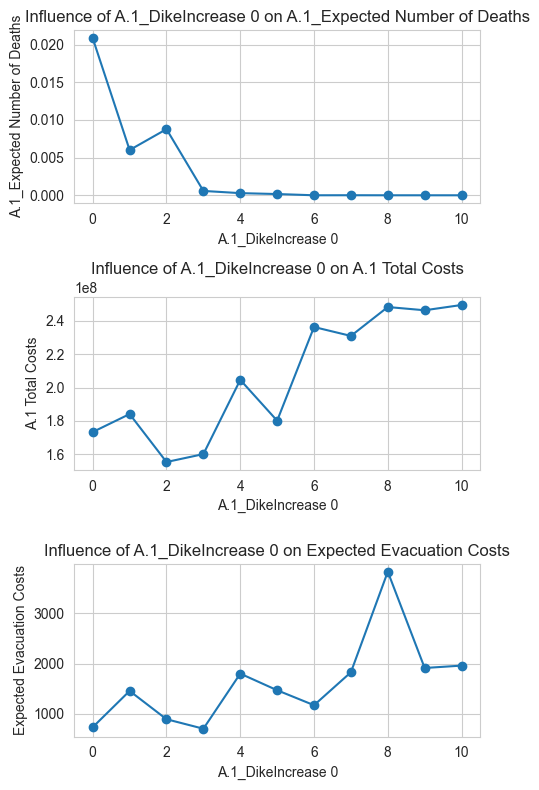

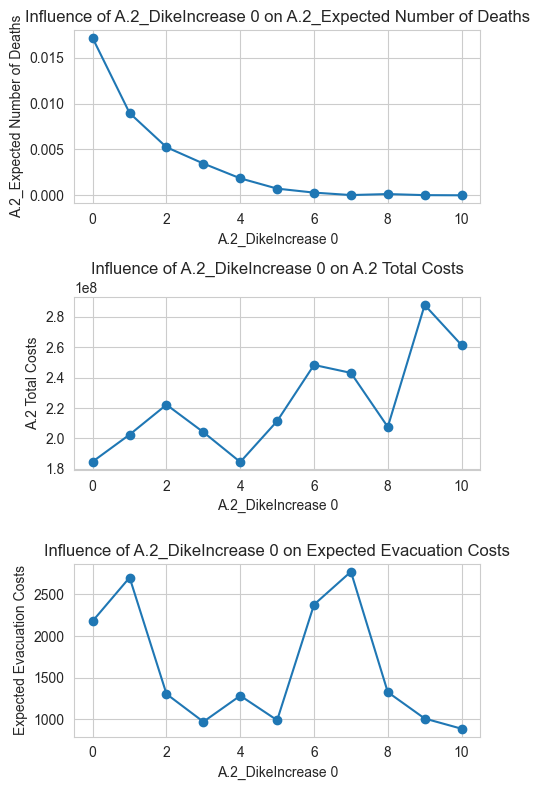

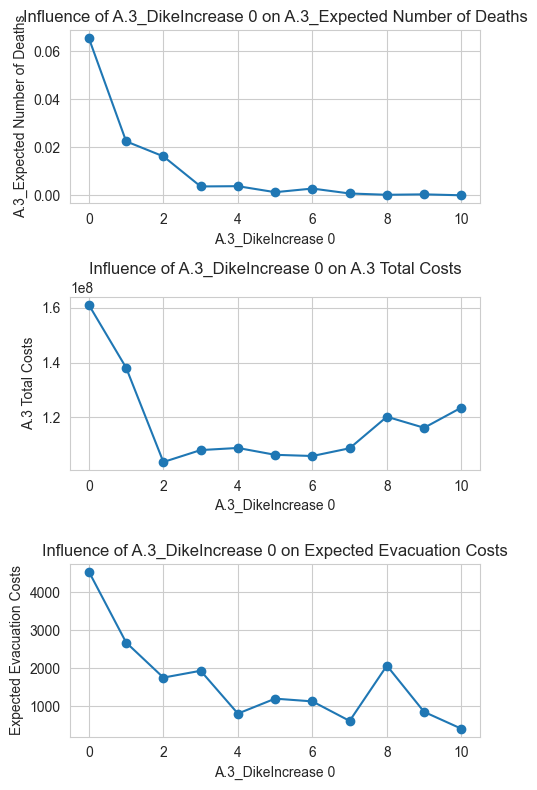

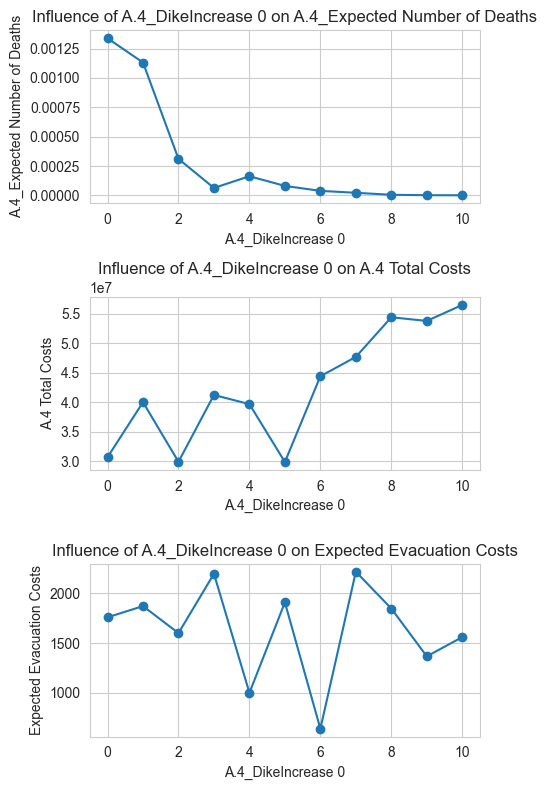

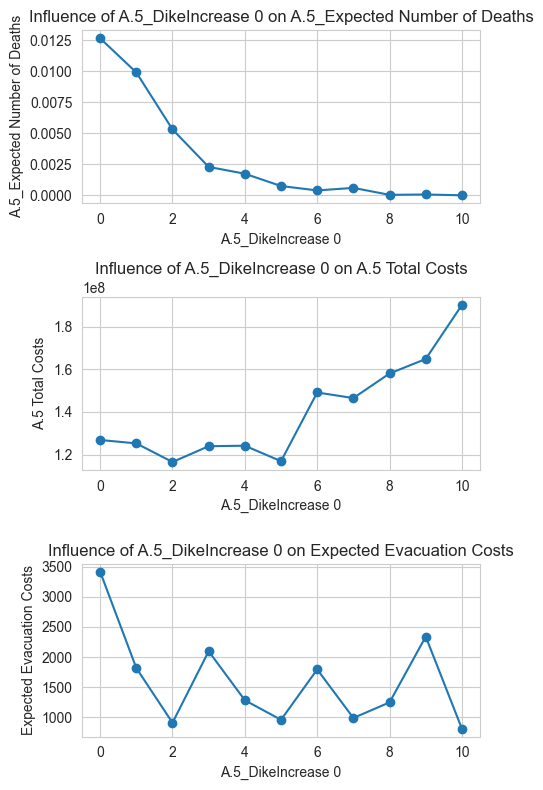

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `experiments` and `outcomes` are DataFrames obtained from the EMA Workbench results
experiments_df = pd.DataFrame(experiments)
outcomes_df = pd.DataFrame(outcomes)

# Combine experiments and outcomes into a single DataFrame
combined_df = pd.concat([experiments_df, outcomes_df], axis=1)

# Define the range of interest
lever_prefix = 'A.{}_DikeIncrease 0'
outcome_prefix = 'A.{}_Expected Number of Deaths'
total_costs_prefix = 'A.{} Total Costs'
general_outcome = 'Expected Evacuation Costs'

# Plot for each lever and corresponding outcomes from A.1 to A.5
for i in range(1, 6):
    lever_name = lever_prefix.format(i)
    expected_deaths_name = outcome_prefix.format(i)
    total_costs_name = total_costs_prefix.format(i)
    outcome_names = [expected_deaths_name, total_costs_name, general_outcome]  # Include all relevant outcomes

    # Group by the lever values and calculate mean of outcomes
    grouped_df = combined_df.groupby(lever_name)[outcome_names].mean().reset_index()

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 8))

    for j, outcome in enumerate(outcome_names):
        axes[j].plot(grouped_df[lever_name], grouped_df[outcome], marker='o')
        axes[j].set_title(f'Influence of {lever_name} on {outcome}')
        axes[j].set_xlabel(lever_name)
        axes[j].set_ylabel(outcome)

    plt.tight_layout()
    plt.show()



In [17]:
from ema_workbench.em_framework import get_SALib_problem

problem = get_SALib_problem(dike_model.uncertainties)
problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [29]:
for policy in dike_model.levers:
    print(repr(policy))

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [35]:
from ema_workbench import Policy
from itertools import product

# Define a base policy where all other levers have fixed values (all RfR values set to 0)
base_policy = {
    '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0,
    '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0,
    '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0,
    '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0,
    '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0,
    'EWS_DaysToThreat': 0,
    'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0,
    'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0,
    'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0,
    'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0,
    'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0
}

# Define the range for A.2_DikeIncrease 0
a2_dike_increase_values = range(11)  # Values from 0 to 10

# Create policies with A.2_DikeIncrease 0 ranging from 0 to 10
policies_sobol = []

for value in a2_dike_increase_values:
    policy_name = f'policy_A2_DikeIncrease_{value}'
    policy_values = base_policy.copy()
    policy_values['A.2_DikeIncrease 0'] = value
    
    policies_sobol.append(Policy(policy_name, **policy_values))

# Display the number of defined policies
print(f'Total number of policies: {len(policies_sobol)}')

policies_sobol

Total number of policies: 11


[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 1, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

In [36]:
from SALib.analyze.sobol import analyze

from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import Samplers
from ema_workbench.em_framework import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
    experiments_sobol, results_sobol = evaluator.perform_experiments(10, policies=policies_sobol,
                                                         uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 6 workers
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 400 scenarios * 11 policies * 1 model(s) = 4400 experiments

100%|██████████████████████████████████████| 4400/4400 [12:59<00:00,  5.64it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [46]:
from SALib.analyze.sobol import analyze

sobol_results = {}
for policy in experiments_sobol.policy.unique():
    logical = experiments_sobol.policy == policy
    y = results_sobol['A.3 Total Costs'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

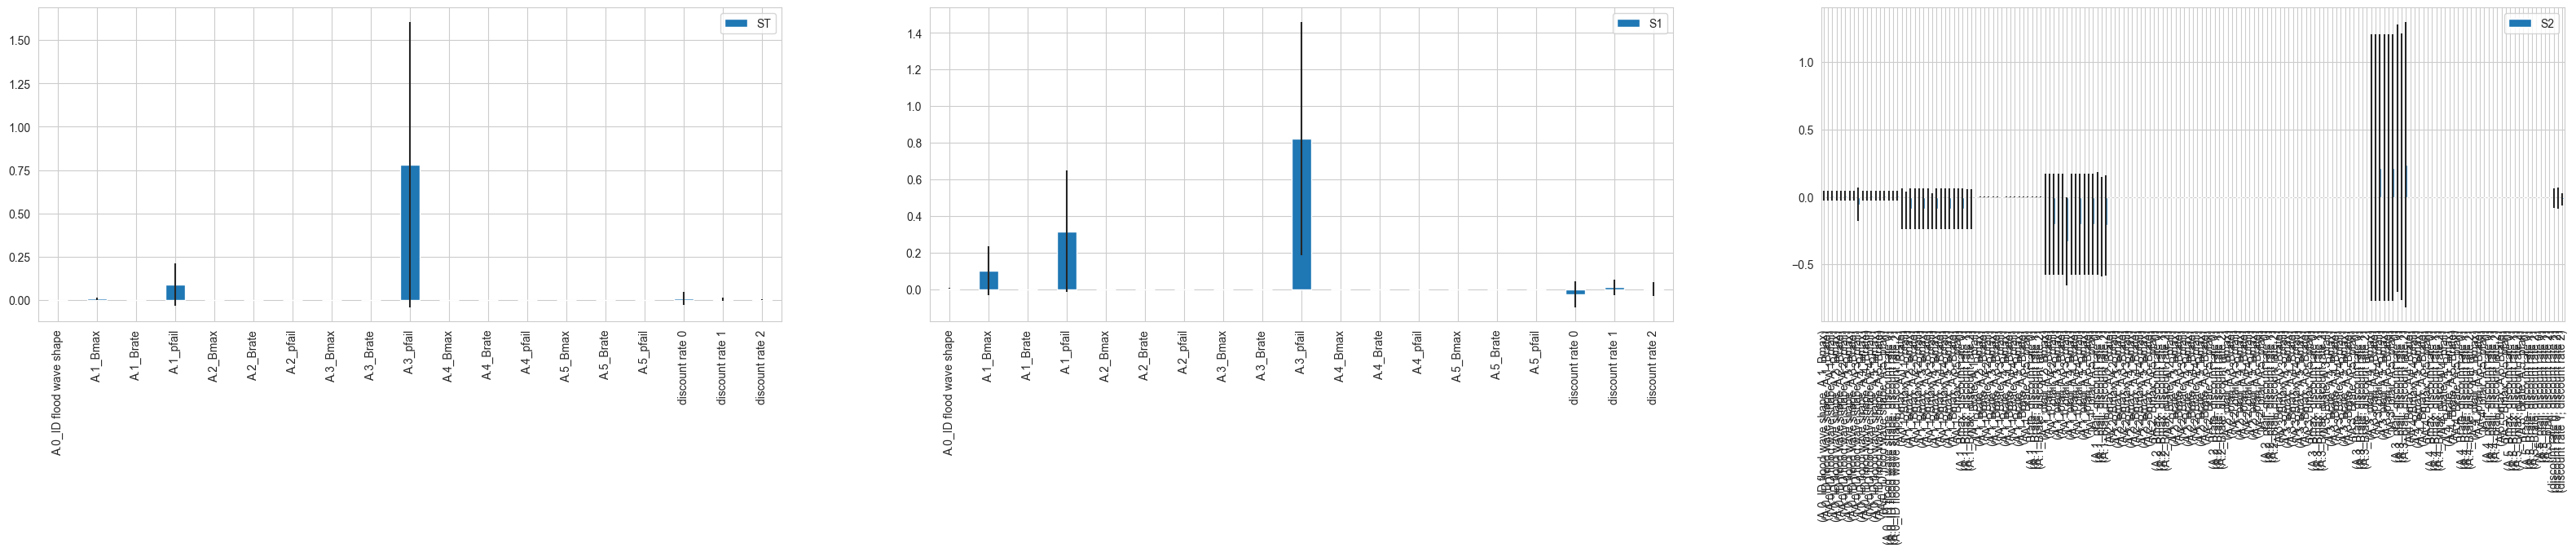

In [68]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(40, 5)
indices.plot(ax=axes)
plt.show()

# fig, axes = plt.subplots(nrows=3, ncols=1)
# fig.set_size_inches(10, 15)  # Adjust the figure size for better readability
# 
# # Assuming 'indices' is a DataFrame or has a 'plot' method
# # that can take 'ax' as an argument
# indices.plot(ax=axes[0])
# indices.plot(ax=axes[1])
# indices.plot(ax=axes[2])
# 
# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

Axes(0.125,0.653529;0.775x0.226471)


In [48]:
from ema_workbench.analysis import feature_scoring

In [50]:
cleaned_experiments_sobol = experiments_sobol.drop(columns=[l.name for l in dike_model.levers])

scores = feature_scoring.get_feature_scores_all(cleaned_experiments_sobol,results_sobol)

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


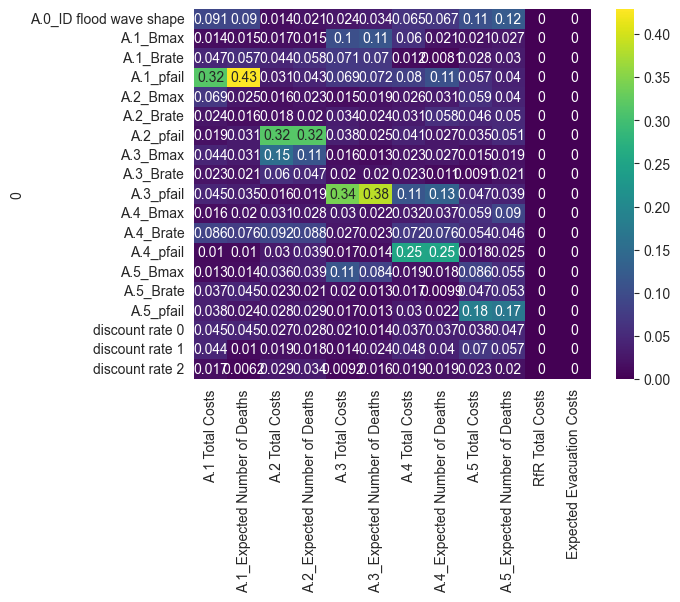

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


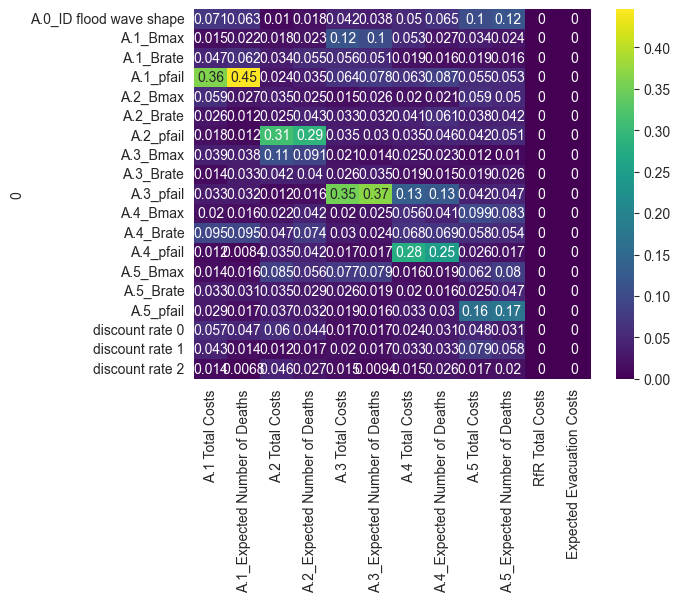

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


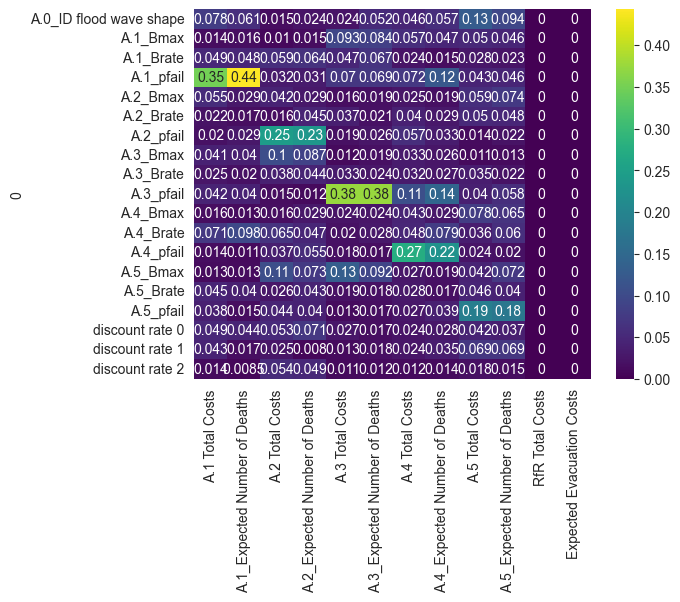

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


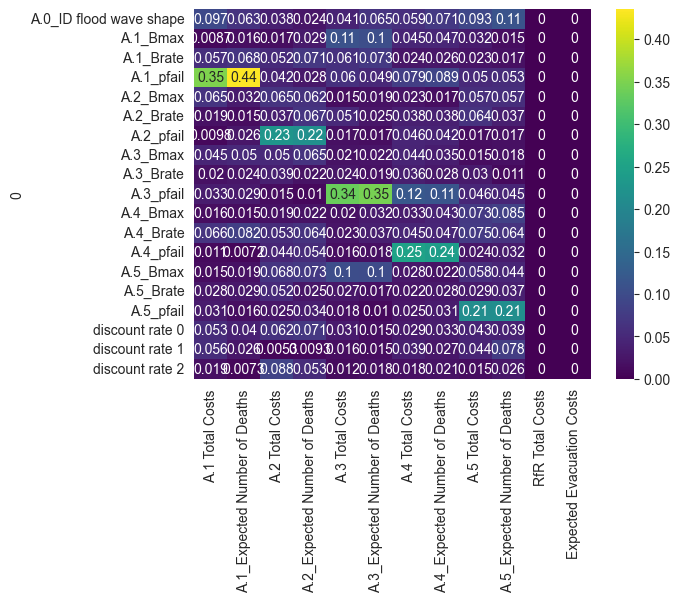

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


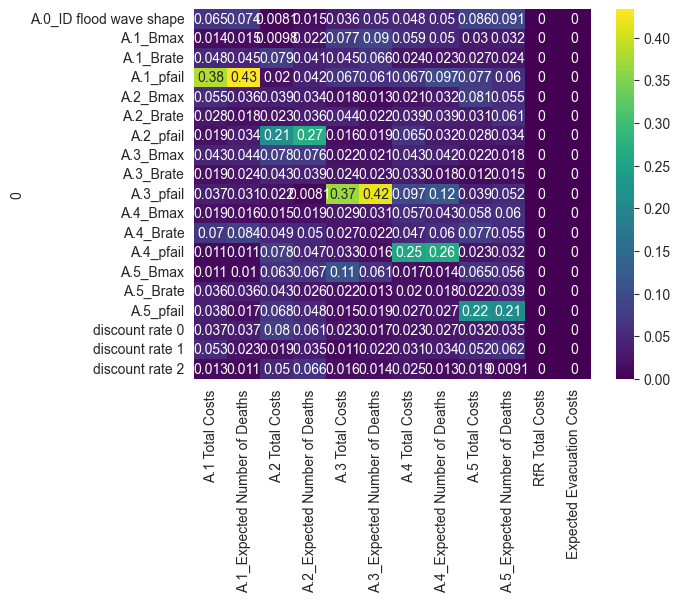

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


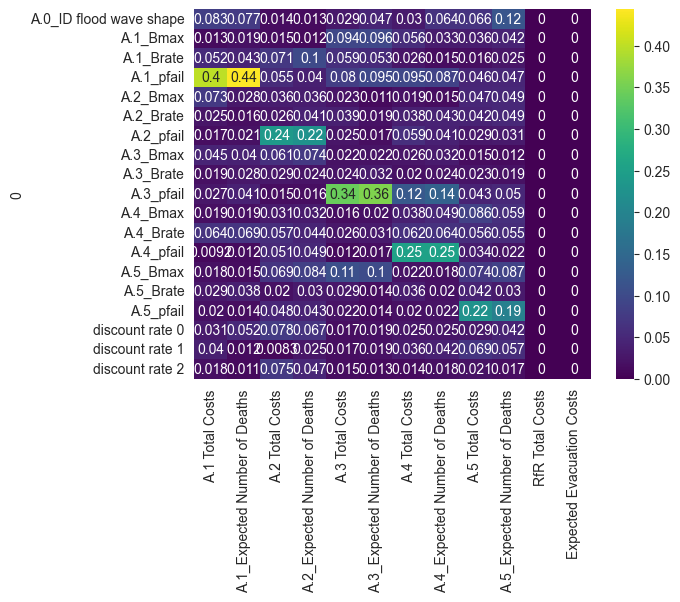

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


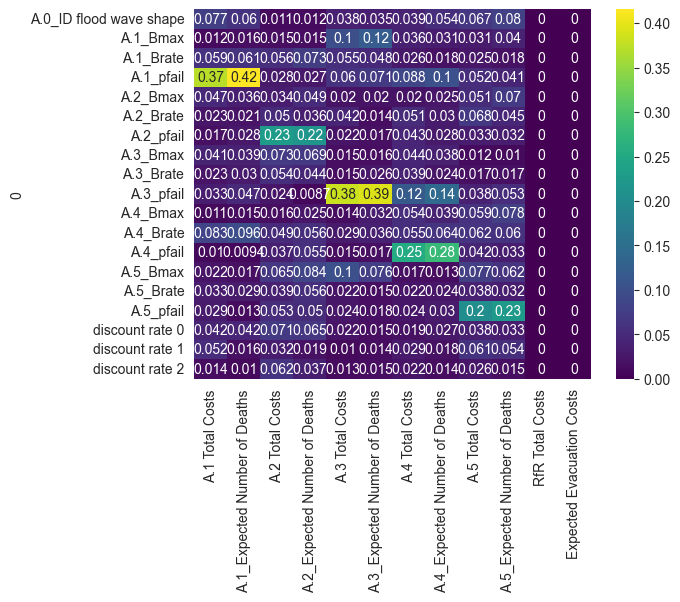

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


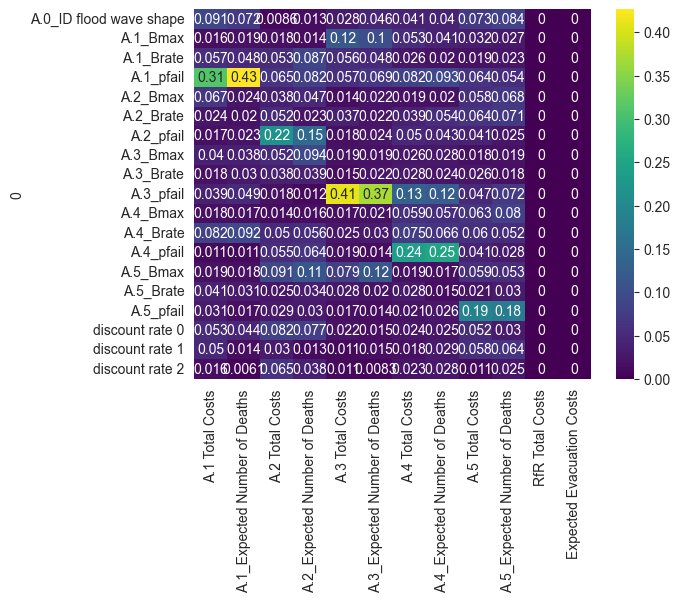

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


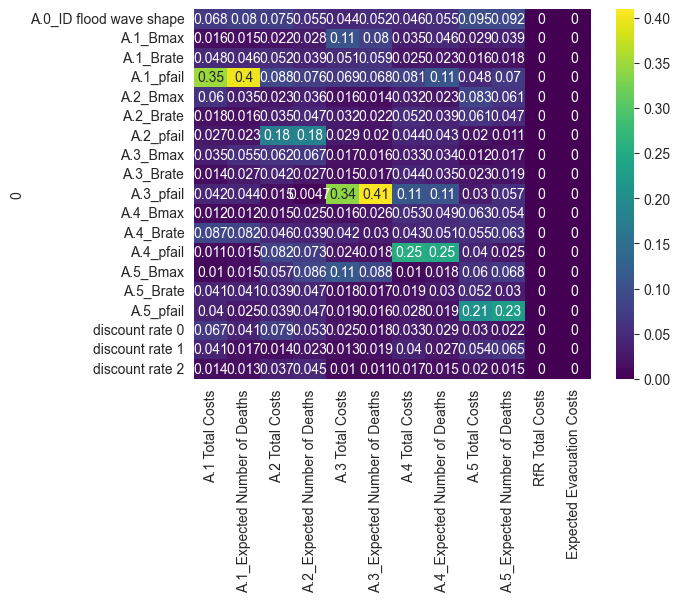

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


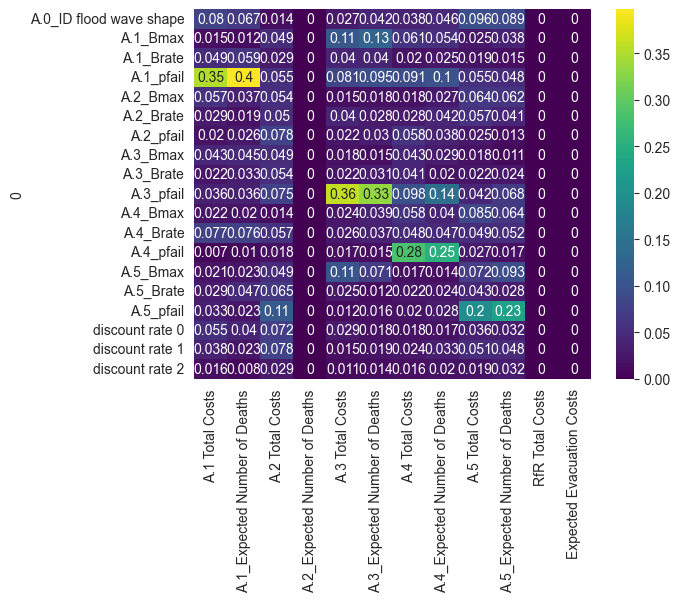

C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\julia\PycharmProjects\EPA141A-Model-based-decision-making\.venv\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


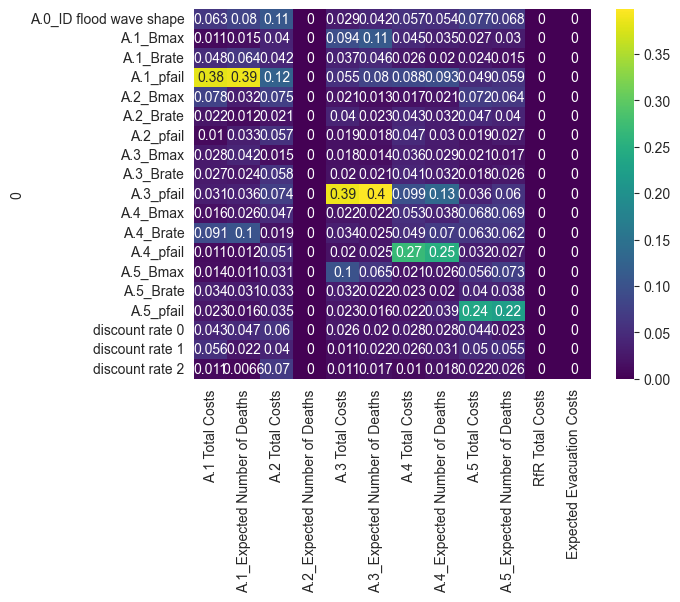

In [74]:
import seaborn as sns
cleaned_experiments_sobol = experiments_sobol.drop(columns=[l.name for l in dike_model.levers])

for policy in experiments_sobol.policy.unique():
    logical = experiments_sobol.policy == policy
    subset_results = {k:v[logical] for k,v in results_sobol.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments_sobol[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()